### This notebook delves into the continued issue of trying to determine which subset of subjects was employed, if a behavioral flag was employed, and further, some new analyses are conducted.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import math, random, warnings
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, pearsonr

warnings.filterwarnings("ignore")

### Essentially below the cleaning operations from 'clean_SST' are condensed into minimally altered functions to allow their ease of use in being run on 6 different data sources.

As a sanity check, one can compare the results from the Clean SST notebook with the results obtained from the below analysis on df 1 (as they use the same subject source).

In [2]:
def check_line_up(df):
    return len(df.src_subject_id.unique()) == 1

def check_subj_lineup(df):
    '''This function is new as I noticed that there were a few subjects where the NARGUID and
    src_subject_id didnt lineup, this just drops those, so that they are interchangable, and correct subject
    counts can be assured'''
    
    group = df.groupby('NARGUID')
    check_lineup = ~group.apply(check_line_up)
    weird = check_lineup[check_lineup].index

    to_drop = df[df['NARGUID'].isin(weird)].index
    df = df.drop(to_drop, axis=0)

    group = df.groupby('NARGUID')
    if np.sum(group.apply(len) != 360) != 0:
        print('Warning missing')

    group = df.groupby('src_subject_id')
    if np.sum(group.apply(len) != 360) != 0:
        print('Warning missing')
        
    return df

def set_trial_type(SST_concat):

    SST_concat['Procedure[SubTrial]'].loc[SST_concat['Procedure[SubTrial]'].isnull()] =\
        SST_concat['Procedure[Trial]'] 

    SST_concat['trial_type'] =\
        SST_concat['Procedure[SubTrial]'].replace('VariableStopTrial.*', 'StopTrial', regex=True)
    
    return SST_concat

def fix_resps(SST_concat):
    go_trial_mask = SST_concat.loc[SST_concat['Procedure[SubTrial]'] == 'GoTrial']
    go_trial_idx = go_trial_mask[go_trial_mask==True].index
    
    #the response recordings are inconsistent in type (str, int, float) this fixes that 
    cresp_replace = {'2.0': 2.0,
                     '1.0': 1.0,
                     '3.0': 3.0,
                     '4.0': 4.0,
                     '1,{LEFTARROW}': 1.0,
                     '2,{RIGHTARROW}': 2.0}

    resp_replace = {'2.0': 2.0,
                    '1.0': 1.0,
                    '3.0': 3.0,
                    '4.0': 4.0,
                    '{LEFTARROW}': 1.0,
                    '{RIGHTARROW}': 2.0}

    SST_concat['Go.RESP'].replace(to_replace=resp_replace, inplace=True)
    SST_concat['Go.RESP'] = SST_concat['Go.RESP'].astype('float')
    
    SST_concat['Go.CRESP'].replace(to_replace=cresp_replace, inplace=True)
    SST_concat['Go.CRESP'] = SST_concat['Go.CRESP'].astype('float')
    
    # In the original code these replacements were missing, but it
    # did not seem to effect anything
    SST_concat['Fix.RESP'].replace(to_replace=resp_replace, inplace=True)
    SST_concat['Fix.RESP'] = SST_concat['Fix.RESP'].astype(float)

    SST_concat['StopSignal.RESP'].replace(to_replace=resp_replace, inplace=True)
    SST_concat['StopSignal.RESP'] = SST_concat['StopSignal.RESP'].astype(float)

    SST_concat['SSD.RESP'].replace(to_replace=resp_replace, inplace=True)
    SST_concat['SSD.RESP'] = SST_concat['SSD.RESP'].astype(float)
    
    return SST_concat

def switch(x):
    
    if x == 1:
        return 2
    elif x == 2:
        return 1
    elif x == 3:
        return 4
    elif x == 4:
        return 3
    else:
        return np.nan

def switch_df(df):
    ''' This function is new, it optional applies the choice response switch according
    to the flags provided in the NDA 2.0 SST summary csv.'''
    
    summary_2_df = pd.read_csv('/home/sage/work/ABCD2p0NDA/abcd_sst02.txt', sep='\t', skiprows=[1])
    switch_subjs = np.array(summary_2_df[summary_2_df['tfmri_sst_beh_switchflag'] == 1].src_subject_id)

    for subj in df.src_subject_id.unique():
        if subj in switch_subjs:
            subj_inds = df[df.src_subject_id == subj].index

            for col in ['Go.RESP', 'Fix.RESP', 'StopSignal.RESP', 'SSD.RESP']:
                df.loc[subj_inds, col] = df.loc[subj_inds, col].apply(switch)

    return df

def set_correct_go(df):

    df['correct_go_response'] = np.NaN

    df['correct_go_response'].loc[(~df['Go.RESP'].isnull()) & 
                                  (df['Go.CRESP'] == df['Go.RESP'])] = float(1)

    df['correct_go_response'].loc[(df['Go.RESP'].isnull()) & 
                                  (df['Go.CRESP'] == df['Fix.RESP'])] = float(1)


    df['correct_go_response'].loc[(~df['Go.RESP'].isnull()) & 
                                  (df['Go.CRESP'] != df['Go.RESP']) &
                                  (df['trial_type'] == 'GoTrial')] = float(0)


    df['correct_go_response'].loc[(df['Go.RESP'].isnull()) & 
                                  (df['Go.CRESP'] != df['Fix.RESP']) &
                                  (df['trial_type'] == 'GoTrial')] = float(0)


    df['correct_go_response'].loc[(df['Go.RESP'].isnull()) & (df['Fix.RESP'].isnull()) & 
                                  (df['trial_type'] == 'GoTrial')] = 'omission'
    
    return df

def set_correct_stop(SST_concat):
    
    SST_concat['correct_stop'] = np.NaN
    
    crt_stop_msk = ((SST_concat['StopSignal.RESP'].isnull()) &
                    (SST_concat['Fix.RESP'].isnull()) &
                    (SST_concat['SSD.RESP'].isnull()) &
                    (SST_concat['trial_type'] == 'StopTrial'))
                    
                    
    SST_concat.loc[crt_stop_msk, 'correct_stop'] = float(1)
    
    inc_stop_msk = ((~(SST_concat['StopSignal.RESP'].isnull()) |
                     ~(SST_concat['Fix.RESP'].isnull())  |
                     ~(SST_concat['SSD.RESP'].isnull())) &
                      (SST_concat['trial_type'] == 'StopTrial'))
    SST_concat.loc[inc_stop_msk, 'correct_stop'] = float(0)
    
    return SST_concat

def set_correct_stim(SST_concat):

    SST_concat['correct_stimulus_mapping_1'] = np.NaN
    SST_concat['correct_stimulus_mapping_2'] = np.NaN
    
    SST_concat.loc[SST_concat['Stimulus'] == 'images/Right_Arrow.bmp', 'correct_stimulus_mapping_1'] = SST_concat.loc[SST_concat['Stimulus'] == 'images/Right_Arrow.bmp']['Go.CRESP'].dropna().unique()[0]
    SST_concat.loc[SST_concat['Stimulus'] == 'images/Right_Arrow.bmp', 'correct_stimulus_mapping_2'] = SST_concat.loc[SST_concat['Stimulus'] == 'images/Right_Arrow.bmp']['Go.CRESP'].dropna().unique()[1]

    SST_concat.loc[SST_concat['Stimulus'] == 'images/Left_Arrow.bmp', 'correct_stimulus_mapping_1'] = SST_concat.loc[SST_concat['Stimulus'] == 'images/Left_Arrow.bmp']['Go.CRESP'].dropna().unique()[0]
    SST_concat.loc[SST_concat['Stimulus'] == 'images/Left_Arrow.bmp', 'correct_stimulus_mapping_2'] = SST_concat.loc[SST_concat['Stimulus'] == 'images/Left_Arrow.bmp']['Go.CRESP'].dropna().unique()[1]
    
    SST_concat['correct_stop_mapping'] = np.NaN 
    SST_concat['correct_stop_mapping'].loc[(SST_concat['correct_stop'] == 0) & (~SST_concat['SSD.RESP'].isnull()) &\
                                           ((SST_concat['SSD.RESP'] == SST_concat['correct_stimulus_mapping_1']) | (SST_concat['SSD.RESP'] == SST_concat['correct_stimulus_mapping_2']))] = float(1)

    SST_concat['correct_stop_mapping'].loc[(SST_concat['correct_stop'] == 0) & (~SST_concat['SSD.RESP'].isnull()) &\
                                           (SST_concat['SSD.RESP'] != SST_concat['correct_stimulus_mapping_1']) & (SST_concat['SSD.RESP'] != SST_concat['correct_stimulus_mapping_2'])] = float(0)

    SST_concat['correct_stop_mapping'].loc[(SST_concat['correct_stop'] == 0) & (SST_concat['SSD.RESP'].isnull()) & (~SST_concat['StopSignal.RESP'].isnull()) &\
                                           ((SST_concat['StopSignal.RESP'] == SST_concat['correct_stimulus_mapping_1']) | (SST_concat['StopSignal.RESP'] == SST_concat['correct_stimulus_mapping_2']))] = float(1)

    SST_concat['correct_stop_mapping'].loc[(SST_concat['correct_stop'] == 0) & (SST_concat['SSD.RESP'].isnull()) & (~SST_concat['StopSignal.RESP'].isnull()) &\
                                           ((SST_concat['StopSignal.RESP'] != SST_concat['correct_stimulus_mapping_1']) & (SST_concat['StopSignal.RESP'] != SST_concat['correct_stimulus_mapping_2']))] = float(0)
    
    SST_concat['correct_stop_mapping'].loc[(SST_concat['correct_stop'] == 0) & (SST_concat['SSD.RESP'].isnull()) & (SST_concat['StopSignal.RESP'].isnull()) & (~SST_concat['Fix.RESP'].isnull()) &\
                                           ((SST_concat['Fix.RESP'] == SST_concat['correct_stimulus_mapping_1']) | (SST_concat['Fix.RESP'] == SST_concat['correct_stimulus_mapping_2']))] = float(1)

    SST_concat['correct_stop_mapping'].loc[(SST_concat['correct_stop'] == 0) & (SST_concat['SSD.RESP'].isnull()) & (SST_concat['StopSignal.RESP'].isnull()) & (~SST_concat['Fix.RESP'].isnull()) &\
                                           ((SST_concat['Fix.RESP'] != SST_concat['correct_stimulus_mapping_1']) & (SST_concat['Fix.RESP'] != SST_concat['correct_stimulus_mapping_2']))] = float(0)
    return SST_concat

def set_correct_go_rt(SST_concat):

    go_fix_resp = (~SST_concat['Fix.RESP'].isnull()) & \
                  (SST_concat['Go.RESP'].isnull()) & \
                  (SST_concat['trial_type'] == 'GoTrial')
    go_fix_idx = go_fix_resp[go_fix_resp == True].index


    SST_concat['go_rt_adjusted'] = SST_concat['Go.RT'].copy()
    SST_concat['go_rt_adjusted'][go_fix_idx] = SST_concat.loc[go_fix_idx]['Go.Duration'] +  \
                                               SST_concat.loc[go_fix_idx]['Fix.RT']
    
    return SST_concat

def set_correct_stop_rt(SST_concat):
    stop_trial_mask = (SST_concat['trial_type'] == 'StopTrial')
    stop_trial_idx = stop_trial_mask[stop_trial_mask == True].index

    SST_concat['stop_rt_adjusted'] = SST_concat['StopSignal.RT']

    stop_fix_resp = (~SST_concat['Fix.RESP'].isnull()) & \
                    (SST_concat['StopSignal.RESP'].isnull()) & \
                    ((SST_concat['trial_type'] == 'StopTrial') & (SST_concat['correct_stop'] == 0))
    stop_fix_idx = stop_fix_resp[stop_fix_resp == True].index

    stop_SSD_resp = ~SST_concat['SSD.RESP'].isnull()

    SST_concat['stop_rt_adjusted'][stop_fix_resp] = SST_concat.loc[stop_fix_resp]['StopSignal.Duration'] +\
                                                    SST_concat.loc[stop_fix_resp]['Fix.RT']

    SST_concat['stop_rt_adjusted'][stop_SSD_resp] = SST_concat.loc[stop_SSD_resp]['SSD.RT']

    stop_resp_mask = ((~(SST_concat['StopSignal.RESP'].isnull()) | ~(SST_concat['Fix.RESP'].isnull()) \
                      | ~(SST_concat['SSD.RESP'].isnull())) & \
                      (~SST_concat['stop_rt_adjusted'].isnull()))
    stop_resp_idx = stop_resp_mask[stop_resp_mask == True].index

    SST_concat['stop_rt_adjusted'][stop_resp_idx] = \
            SST_concat['stop_rt_adjusted'][stop_resp_idx] + SST_concat['SSDDur'][stop_resp_idx]

    # Re-calc alt version
    SST_concat['true_stop_rt_adjusted'] = SST_concat['StopSignal.RT']
    SST_concat['true_stop_rt_adjusted'][stop_fix_resp] =\
        SST_concat.loc[stop_fix_resp]['StopSignal.Duration'] + SST_concat.loc[stop_fix_resp]['Fix.RT']
    SST_concat['true_stop_rt_adjusted'][stop_SSD_resp] = SST_concat.loc[stop_SSD_resp]['SSD.RT']

    true_stop_resp_mask = ((~(SST_concat['StopSignal.RESP'].isnull()) | ~(SST_concat['Fix.RESP'].isnull())) & \
                           (~SST_concat['true_stop_rt_adjusted'].isnull()))
    true_stop_resp_idx = true_stop_resp_mask[true_stop_resp_mask == True].index

    SST_concat['true_stop_rt_adjusted'][true_stop_resp_idx] =\
        SST_concat['true_stop_rt_adjusted'][true_stop_resp_idx] + SST_concat['SSDDur'][true_stop_resp_idx]
    
    return SST_concat

def set_go_stim_dur(SST_concat):
    SST_concat['go_stim_duration'] = SST_concat['Go.RT'].copy()
    SST_concat['go_stim_duration'].loc[SST_concat['Go.RT'] == 0] = SST_concat['Go.Duration'].loc[SST_concat['Go.RT'] == 0]

    SST_concat['go_stim_duration'].loc[~(SST_concat['SSD.RESP'].isnull())] = SST_concat.loc[~SST_concat['SSD.RESP'].isnull()]['SSD.RT']
    SST_concat['go_stim_duration'].loc[(SST_concat['SSD.RT']  == 0)] = SST_concat.loc[SST_concat['SSD.RT'] == 0]['SSDDur']
    return SST_concat

def clean_df(df, switch=False):
    '''This combines all of the above function into one function'''
    
    # Extra check
    df = check_subj_lineup(df)
    
    df = set_trial_type(df)
    df = fix_resps(df)
    
    if switch:
        df = switch_df(df)
    
    df = set_correct_go(df)
    df = set_correct_stop(df)
    df = set_correct_stim(df)
    df = set_correct_go_rt(df)
    df = set_correct_stop_rt(df)
    df = set_go_stim_dur(df)
    
    return df

### The next piece is similar to above, but for the SST_Problems script. A number of the non-plotting analysis (not all, but some key ones for comparison) are re-created below in the analysis function, s.t., it can easily be used to compare between dataframes

In [3]:
def stop_fail_accuracy(df):
    try: 
        acc = len(df.loc[df['correct_stop_mapping'] == 1]) / len(df.loc[df['correct_stop'] == 0])
    except ZeroDivisionError:
        acc = np.NaN
    return acc

def go_accuracy(df):
    try:
        denom = len(df.loc[(df['correct_go_response'] != 'omission') & (df['trial_type'] == 'GoTrial')])
        acc = len(df.loc[df['correct_go_response'] == 1]) / denom
    except ZeroDivisionError:
        acc = np.NaN
    return acc

def zero_SSD_acc(df): 
    try: 
        acc = len(df.loc[(df['SSDDur'] == 0) & (df['correct_stop'] == 1.0)]) / len(df.loc[df['SSDDur'] == 0])
    except ZeroDivisionError:
        acc = np.NaN
    
    return acc   

def analysis(SST_concat):
    '''The point of this messy analysis function is to condense the 1 or 2 number results from the
    original SST_problems script into easily comparable numbers.'''
    
    print('n_subjects =', len(SST_concat.NARGUID.unique()))
    
    group_narguid = SST_concat.groupby('NARGUID')
    
    narguid_stop_duration = group_narguid.apply(lambda x: 
                                                np.mean(x.loc[x['trial_type'] == 'StopTrial']['go_stim_duration']))
    narguid_go_duration = group_narguid.apply(lambda x: 
                                              np.mean(x.loc[x['trial_type'] == 'GoTrial']['go_stim_duration']))
    
    print('1', len(SST_concat.loc[(SST_concat['trial_type'] == 'StopTrial') & (SST_concat['go_stim_duration'] == 0)]) / \
               len(SST_concat.loc[SST_concat['trial_type'] == 'StopTrial']))
    
    print('2', np.mean(narguid_go_duration) - np.mean(narguid_stop_duration))
    
    narguid_average_stop_rt = group_narguid.apply(lambda x: 
                                                  np.mean(x.loc[x['correct_stop'] == 0]['stop_rt_adjusted']))
    print('stop failure rt:', np.mean(narguid_average_stop_rt))
    print('sdev:', np.std(narguid_average_stop_rt))
    
    narguid_average_go_rt = group_narguid.apply(lambda x: np.mean(x.loc[(x['correct_go_response'] != 'omission') 
                                                & (x['trial_type'] == 'GoTrial')]['go_rt_adjusted']))
    print('overt go response mean:', np.mean(narguid_average_go_rt))
    print('sdev:', np.std(narguid_average_go_rt))
    
    print('difference beween these:', np.mean(narguid_average_stop_rt) - np.mean(narguid_average_go_rt))
    print('3', sum(np.greater(narguid_average_stop_rt, narguid_average_go_rt)))
    print('4', sum(np.greater(narguid_average_stop_rt, narguid_average_go_rt)) / len(SST_concat['NARGUID'].unique()))
    
    true_narguid_average_stop_rt = group_narguid.apply(lambda x: 
                                                       np.mean(x.loc[x['correct_stop'] == 0]['true_stop_rt_adjusted']))

    print('true stop failure rt:', np.mean(true_narguid_average_stop_rt))
    print('true sdev:', np.std(true_narguid_average_stop_rt))   

    print('true difference beween these:', np.mean(true_narguid_average_stop_rt) - np.mean(narguid_average_go_rt))
    print('5', sum(np.greater(true_narguid_average_stop_rt, narguid_average_go_rt)))
    print('6', sum(np.greater(true_narguid_average_stop_rt, narguid_average_go_rt)) / len(SST_concat['NARGUID'].unique()))
    
    #make a dataframe of rts 
    narguid_df = pd.DataFrame({'stop_rt': narguid_average_stop_rt, 'go_rt':narguid_average_go_rt})
    narguid_df['true_stop_rt'] = true_narguid_average_stop_rt

    #add accuracies to that dataframe
    narguid_df['stop_acc'] = np.NaN
    narguid_df['go_acc'] = np.NaN

    narguid_df['go_acc'] = group_narguid.apply(lambda x: go_accuracy(x))
    narguid_df['stop_acc'] = group_narguid.apply(lambda x: stop_fail_accuracy(x))

    #if a participant had no stop failures, then they need to be dropped 
    narguid_df = narguid_df.dropna(how='any')
    
    mu = np.mean(narguid_df['go_rt'] - narguid_df['stop_rt'])
    N = len(narguid_df)
    sigma = np.std(narguid_df['go_rt'] - narguid_df['stop_rt'])
    print('7', stats.norm.interval(0.95, loc=mu, scale=sigma/math.sqrt(N)))
    
    mu = np.mean(narguid_df['go_rt'] - narguid_df['true_stop_rt'])
    N = len(narguid_df)
    sigma = np.std(narguid_df['go_rt'] - narguid_df['true_stop_rt'])
    print('8', stats.norm.interval(0.95, loc=mu, scale=sigma/math.sqrt(N)))
    
    mu = np.mean(narguid_df['stop_acc'] - narguid_df['go_acc'])
    N = len(narguid_df)
    sigma = np.std(narguid_df['stop_acc'] - narguid_df['go_acc'])
    print('9', stats.norm.interval(.95, loc=mu,scale=sigma/math.sqrt(N)))
    
    print('stop acc', np.mean(narguid_df['stop_acc']))
    print('go acc', np.mean(narguid_df['go_acc']))
    
    print('10', len(SST_concat.loc[SST_concat['SSDDur'] == 0])/\
          len(SST_concat.loc[SST_concat['trial_type'] == 'StopTrial']))
    
    print('11', len(SST_concat.loc[SST_concat['SSDDur'] == 0]))
    
    overlap = len(SST_concat.loc[((SST_concat['SSDDur'] == 0) & 
                              (SST_concat['SSD.RT'] < 50) &
                              (SST_concat['SSD.RT'] > 0))])
    print('12', overlap / len(SST_concat.loc[SST_concat['SSDDur'] == 0]), overlap)
    
    zero_acc = group_narguid.apply(lambda x: zero_SSD_acc(x))
    print('13', np.mean(zero_acc))
    
    SSD_bug = SST_concat.loc[(SST_concat['SSD.RT'] < 50) & (SST_concat['SSD.RT'] > 0) & (SST_concat['SSDDur'] <=50)]['NARGUID']
    print('14', len(SSD_bug.unique())/ len(SST_concat['NARGUID'].unique()))
    
    print('15', len(SSD_bug) / len(SST_concat))
    print('percent of stop trials', len(SSD_bug) / len(SST_concat.loc[SST_concat['trial_type'] == 'StopTrial']))
    
    drop_zero_ssd_group = SST_concat.set_index('NARGUID').drop(SSD_bug.unique()).groupby('NARGUID')
    drop_zero_acc = drop_zero_ssd_group.apply(lambda x: zero_SSD_acc(x))
    print('16', np.mean(drop_zero_acc))
    
    print('17', len(SST_concat.loc[SST_concat['SSDDur'] > 700]) / len(SST_concat.loc[SST_concat['trial_type'] =='StopTrial']))
    
    print('18', len(SST_concat.loc[(SST_concat['correct_go_response'] == 0) & (SST_concat['TrialCode'] == 'CorrectGo')]))
    print('19', len(SST_concat.loc[(SST_concat['correct_go_response'] == 1) & (SST_concat['TrialCode'] == 'IncorrectGo')])) 
    print('20', len(SST_concat.loc[(SST_concat['correct_stop'] == 0) & (SST_concat['TrialCode'] == 'CorrectStop')]))

In [4]:
def run_full(loc, switch):
    df = pd.read_csv(loc, low_memory=False)
    df = clean_df(df, switch=switch)
    analysis(df)

In [5]:
for i in range(1, 7):
    
    print(i, 'switch == False')
    print()
    
    run_full('merged_data/' + str(i) + '_.csv', switch=False)
    print()
    print('--------')
    print()
    
    print(i, 'switch == True')
    print()
    
    run_full('merged_data/' + str(i) + '_.csv', switch=True)
    print()
    print('--------')
    print()

1 switch == False

n_subjects = 8450
1 0.07896200733814653
2 341.09376178640696
stop failure rt: 495.1063059378985
sdev: 139.79689111616526
overt go response mean: 543.1860337060224
sdev: 95.2038806360494
difference beween these: -48.07972776812386
3 1553
4 0.18378698224852072
true stop failure rt: 459.1403240842832
true sdev: 110.18783822752539
true difference beween these: -84.0457096217392
5 602
6 0.07124260355029585
7 (46.123274341843036, 50.05667572666645)
8 (82.53812173052962, 85.57379204521)
9 (-0.10820971184217351, -0.10367010849338562)
stop acc 0.7857503064764038
go acc 0.8916902166441691
10 0.09099893478518167
11 46131
12 0.1322754763607986 6102
13 0.6017604980235539
14 0.026745562130177515
15 0.0020802103879026955
percent of stop trials 0.012482739574703122
16 0.6276923906725549
17 0.011508265277942163
18 57215
19 520
20 1080

--------

1 switch == True

n_subjects = 8450
1 0.07896200733814653
2 341.09376178640696
stop failure rt: 495.1063059378985
sdev: 139.79689111616526
o

11 31638
12 0.043112712560844556 1364
13 0.6367515961803011
14 0.012354247640199888
15 0.0005602597322475168
percent of stop trials 0.003361558393485101
16 0.6483069238932785
17 0.0012076624097723486
18 44465
19 23275
20 751

--------

6 switch == False

n_subjects = 6690
1 0.06932735426008968
2 332.79403288490437
stop failure rt: 491.0717000620442
sdev: 120.13356534595327
overt go response mean: 544.2207868214309
sdev: 90.78990470116364
difference beween these: -53.149086759386705
3 1033
4 0.15440956651718984
true stop failure rt: 459.28688819810804
true sdev: 98.66474421460153
true difference beween these: -84.93389862332288
5 333
6 0.04977578475336323
7 (51.48817822539252, 54.80999529338531)
8 (83.51004320508747, 86.35775404156223)
9 (-0.10613682458536614, -0.10126456977286274)
stop acc 0.8071167002624716
go acc 0.9108173974415686
10 0.07244145490782262
11 29078
12 0.04298782584771992 1250
13 0.6369995873858284
14 0.01210762331838565
15 0.0005526490616176715
percent of stop trials 0

All relevant corresponding output from published https://github.com/mckenziephagen/ABCD_Stop_Signal/blob/master/scripts/SST_manuscript/SST_problems.ipynb

n_subjects = 7231

1 0.07796524224404186

2 340.6331825934649

stop failure rt: 495.01266545367145

sdev: 139.96034292909457

overt go response mean: 543.6630781157475

sdev: 95.29722256609477

difference beween these: -48.65041266207601

3 1326

4 0.18337712626192781

7 (46.559456555770865, 50.76564197295882)

9 (-0.11187416423722574, -0.10639848790163689)

10 0.09017194486700779

13 0.6045009332058497

14 0.027243811367722307

15 0.0021101276909602177

16 0.0021101276909602177

17 0.008309131978057438

18 57255

19 520

20 1082

### For a more readable version, we narrow it down to just considering 1 and 5, i.e., all avaliable subjects, and filtered by the behavioral performance flag.

In [6]:
for i in [1, 5]:
    
    print(i, 'switch == False')
    print()
    
    run_full('merged_data/' + str(i) + '_.csv', switch=False)
    print()
    print('--------')
    print()
    
    print(i, 'switch == True')
    print()
    
    run_full('merged_data/' + str(i) + '_.csv', switch=True)
    print()
    print('--------')
    print()

1 switch == False

n_subjects = 8450
1 0.07896200733814653
2 341.09376178640696
stop failure rt: 495.1063059378985
sdev: 139.79689111616526
overt go response mean: 543.1860337060224
sdev: 95.2038806360494
difference beween these: -48.07972776812386
3 1553
4 0.18378698224852072
true stop failure rt: 459.1403240842832
true sdev: 110.18783822752539
true difference beween these: -84.0457096217392
5 602
6 0.07124260355029585
7 (46.123274341843036, 50.05667572666645)
8 (82.53812173052962, 85.57379204521)
9 (-0.10820971184217351, -0.10367010849338562)
stop acc 0.7857503064764038
go acc 0.8916902166441691
10 0.09099893478518167
11 46131
12 0.1322754763607986 6102
13 0.6017604980235539
14 0.026745562130177515
15 0.0020802103879026955
percent of stop trials 0.012482739574703122
16 0.6276923906725549
17 0.011508265277942163
18 57215
19 520
20 1080

--------

1 switch == True

n_subjects = 8450
1 0.07896200733814653
2 341.09376178640696
stop failure rt: 495.1063059378985
sdev: 139.79689111616526
o

All subjects e-prime data availible from the fasttrack reccomended series, no exclusions
n_subjects = 8451

By subject,
mean overt go response rt 543.1833 (sd = 95.1986)
mean stop failure rt 459.1527 (sd = 110.1871)
difference = -84.0306

Number of violators: 603
% violators: 7.135%

By subject,
mean over go choice acc: 89.16%
mean stop failure choice acc: 79.29%
stop-go confidence 95% interval: (-0.10822904694210822, -0.10368935291333464)

W/ switch flags applied:
mean over go choice acc: 90.22%
mean stop failure choice acc: 81.17%
stop-go confidence 95% interval: (-0.11150986947489022, -0.10711768687360362)


------------------------------------------


All subjects e-prime data availible from the fasttrack reccomended series, behavioral performance flag based exclusions
n_subjects = 7204

By subject,
mean overt go response rt 542.9531 (sd = 90.6740)
mean stop failure rt 458.1956 (sd = 98.0637)
difference = -84.7574

Number of violators: 355
% violators: 4.927%

By subject,
mean over go choice acc: 90.89%
mean stop failure choice acc: 80.48%
stop-go confidence 95% interval: (-0.10644632845673829, -0.10171330420948616)

W/ switch flags applied:
mean over go choice acc: 91.89%
mean stop failure choice acc: 81.17%
stop-go confidence 95% interval: (-0.10952389103000225, -0.10494349881365193)


------------------------------------------

Reported results from https://github.com/mckenziephagen/ABCD_Stop_Signal/blob/master/scripts/SST_manuscript/SST_problems.ipynb
on a difficult to exactly track down subset of subjects
n_subjects = 7231

***stop failure is incorrectly calculated below, just used for comparison***

By subject,
mean overt go response rt 543.6630 (sd = 95.2972)
mean stop failure rt 495.0127 (sd = 139.9603)
difference = -48.6504

* Note the mean go.rt + standard dev. is extremely similar to the first subset of subjects (this along with other simmilar comparisons strongly suggests they did not use the behavioral flag to stop subjects).

Number of violators: 1326
% violators: 18.338%

By subject,
mean over go choice acc: n/a
mean stop failure choice acc: n/a
stop-go confidence 95% interval: (-0.11187416423722574, -0.10639848790163689)

## We will now conduct some new/additional analysis comparing 1 vs. 5, or rather now renamed to df1 and df2. 

#### df1 is the subset of avaliable subjects downloadable from the ABCD reccomended active fast track release, with the subjects Bisset et al. likely missed (those w/ csv event files) included. df2 is now that same subset of subjects, but with the behavioral flag applied.

In [7]:
# First subset
df1 = pd.read_csv('merged_data/1_.csv', low_memory=False)
df1 = clean_df(df1, switch=False)

# Same subset but w/ behavioral flag applied
df2 = pd.read_csv('merged_data/5_.csv', low_memory=False)
df2 = clean_df(df2, switch=False)

#### We will also create a third df, just called df, that further excludes the bugged ssd subjects, so now we have 3 comparison dfs

In [8]:
## Drop bugged subjects
SSD_bug = df2.loc[(df2['SSD.RT'] < 50) & (df2['SSD.RT'] > 0) & (df2['SSDDur'] <=50)]['src_subject_id']
to_drop_subjs = SSD_bug.unique()
to_drop = df2[df2.src_subject_id.isin(to_drop_subjs)].index

df = df2.drop(to_drop, axis=0)
df = switch_df(df)

In [9]:
analysis(df)

n_subjects = 7115
1 0.06889435464980088
2 332.08662215975824
stop failure rt: 492.50811316114317
sdev: 117.60986596231265
overt go response mean: 543.846149347633
sdev: 90.50057353284646
difference beween these: -51.338036186489774
3 1105
4 0.15530569219957835
true stop failure rt: 460.48401059834134
true sdev: 95.76969595176892
true difference beween these: -83.3621387492916
5 355
6 0.049894588896697116
7 (49.78843555198497, 52.887636820997336)
8 (82.0439713258757, 84.68030617270955)
9 (-0.10477979697953614, -0.10007876715208129)
stop acc 0.8077516838031726
go acc 0.9101809658689644
10 0.06889435464980088
11 29411
12 0.0 0
13 0.6483069238932785
14 0.0
15 0.0
percent of stop trials 0.0
16 0.6483069238932785
17 0.0012227687983134223
18 40237
19 23
20 725


## Issue 1 make plot by SSD duration

#### One follow up analysis is to consider the different between overt go rt and failed stop rt as a function of the SSD duration of the trial

In [10]:
group = df.groupby('src_subject_id')

go_rts_by_subj = group.apply(lambda x: np.mean(x.loc[(x['correct_go_response'] != 'omission') 
                 & (x['trial_type'] == 'GoTrial')]['go_rt_adjusted']))

def get_rt_dif(df):
    
    by_subj_group = df.groupby('src_subject_id')
    
    stop_mean_rts = by_subj_group.apply(lambda x: np.mean(x.loc[x['correct_stop'] == 0]['true_stop_rt_adjusted']))
    stop_mean_rts = stop_mean_rts.dropna()
    
    return stop_mean_rts - go_rts_by_subj.loc[stop_mean_rts.index]

by_ssd_group = df.groupby('SSDDur')
difs = by_ssd_group.apply(get_rt_dif)

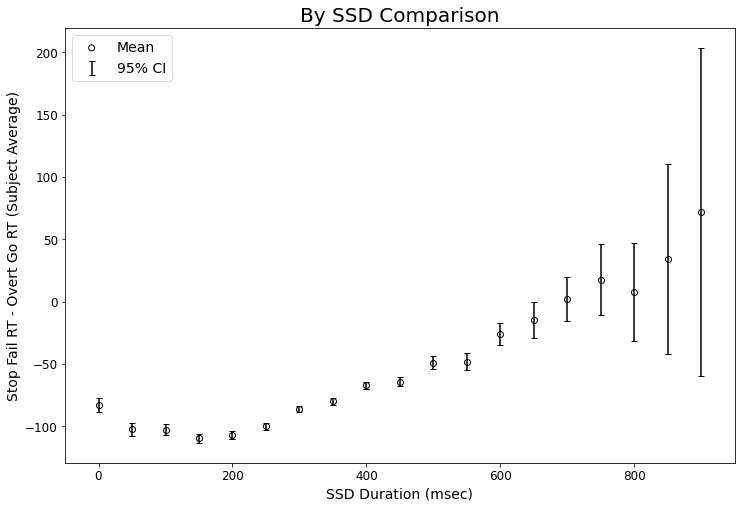

In [11]:
plt.figure(figsize=(12, 8))

for x in difs.index.levels[0]:
    mu = np.mean(difs.loc[x])
    N = len(difs.loc[x])
    sigma = np.std(difs.loc[x])
    c_int = stats.norm.interval(0.95, loc=mu, scale=sigma/math.sqrt(N))
    plt.errorbar(x, mu, yerr=mu - c_int[0], fmt='o', color='black', capsize=3, fillstyle='none')

plt.xlabel('SSD Duration (msec)', fontsize=14)
plt.ylabel('Stop Fail RT - Overt Go RT (Subject Average)', fontsize=14)
plt.title('By SSD Comparison', fontsize=20)
plt.xlim(-50, 950)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.scatter(-100, 0, color='black', label='Mean', facecolors='none')
plt.errorbar(-100, 0, yerr=0, fmt='none', color='black', capsize=3, fillstyle='none', label='95% CI')
plt.legend(prop={'size': 14})
plt.savefig('plots/By_SSD_Comparison.png', dpi=500)

## Issue 2 - more

In [12]:
def zero_SSD_count(df):
    return len(df.loc[df['SSDDur'] == 0])

group1 = df1.groupby('NARGUID')
group2 = df2.groupby('NARGUID')

zero_cnt1 = group1.apply(lambda x: zero_SSD_count(x))
zero_cnt2 = group2.apply(lambda x: zero_SSD_count(x))

In [13]:
group = df.groupby('src_subject_id')
zero_cnt = group.apply(lambda x: zero_SSD_count(x))
sum(zero_cnt > 0) / len(zero_cnt)

0.493183415319747

In [14]:
def flex_zero_SSD_count(df):
    return len(df.loc[(df['SSDDur'] == 0) & (df['StopTrial'] > 5)])

zero_cnt = group.apply(lambda x: flex_zero_SSD_count(x))
sum(zero_cnt > 0) / len(zero_cnt)

0.39985945186226285

In [15]:
with open('clean_over1_zeroSSD.txt', 'w') as f:
    for s in zero_cnt[zero_cnt > 0].index:
        f.write(s+'\n')
        

Text(0.5, 0.98, 'Issue 2 - drop behavioral flag comparison (x=0 not shown)')

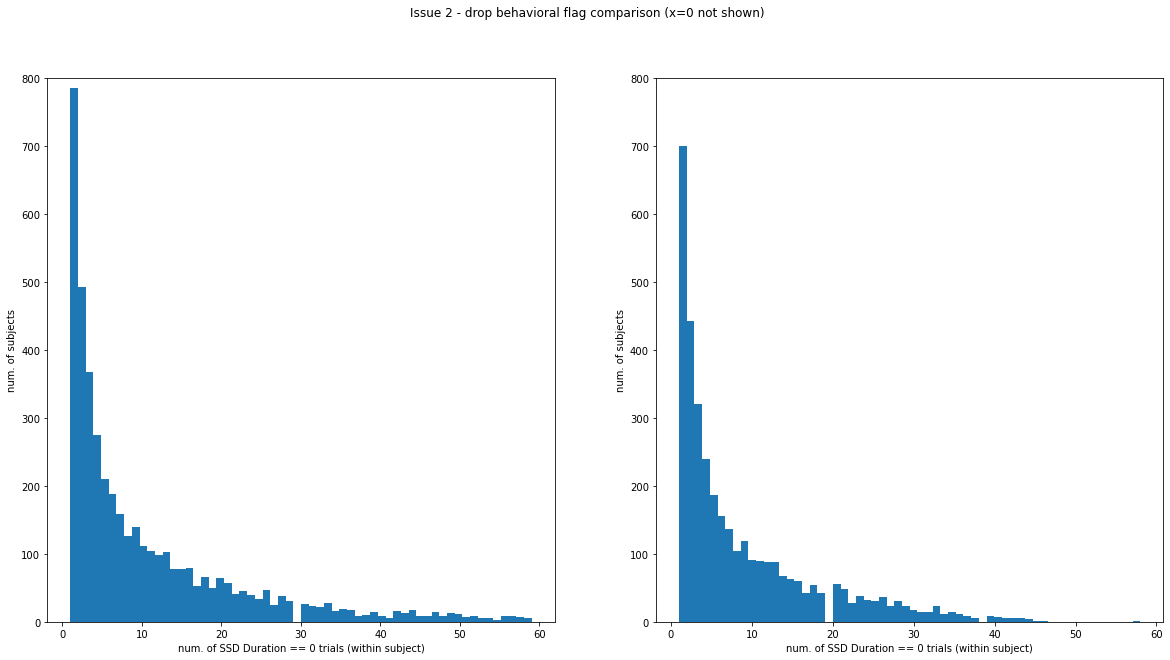

In [16]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
axes[0].hist(zero_cnt1[zero_cnt1 != 0], bins=60)
axes[0].set_ylabel('num. of subjects')
axes[0].set_xlabel('num. of SSD Duration == 0 trials (within subject)')
axes[0].set_ylim(0, 800)

axes[1].hist(zero_cnt2[zero_cnt2 != 0], bins=60)
axes[1].set_ylabel('num. of subjects')
axes[1].set_xlabel('num. of SSD Duration == 0 trials (within subject)')
axes[1].set_ylim(0, 800)

fig.suptitle('Issue 2 - drop behavioral flag comparison (x=0 not shown)')

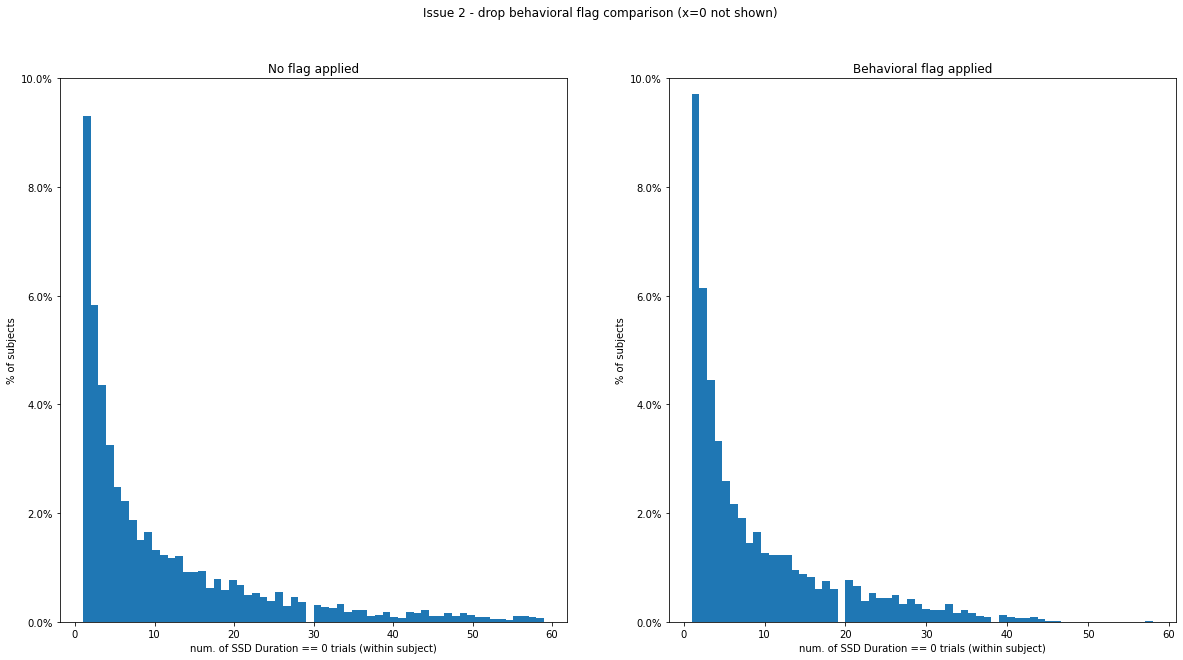

In [17]:
from matplotlib.ticker import PercentFormatter

fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
axes[0].hist(zero_cnt1[zero_cnt1 != 0], bins=60, weights=np.ones(len(zero_cnt1[zero_cnt1 != 0])) / len(zero_cnt1))
axes[0].set_ylabel('% of subjects')
axes[0].set_xlabel('num. of SSD Duration == 0 trials (within subject)')
axes[0].yaxis.set_major_formatter(PercentFormatter(1))
axes[0].set_ylim(0, .1)
axes[0].set_title('No flag applied')

axes[1].hist(zero_cnt2[zero_cnt2 != 0], bins=60, weights=np.ones(len(zero_cnt2[zero_cnt2 != 0])) / len(zero_cnt2))
axes[1].set_ylabel('% of subjects')
axes[1].set_xlabel('num. of SSD Duration == 0 trials (within subject)')
axes[1].yaxis.set_major_formatter(PercentFormatter(1))
axes[1].set_ylim(0, .1)
axes[1].set_title('Behavioral flag applied')

fig.suptitle('Issue 2 - drop behavioral flag comparison (x=0 not shown)')
plt.savefig('plots/Issue2_behavioral_flag_comparison.png', dpi=300)

In [18]:
np.sum(zero_cnt1 > 10) / len(zero_cnt1)

0.17751479289940827

In [19]:
np.sum(zero_cnt2 > 10) / len(zero_cnt2)

0.1529705719044975

In [20]:
np.sum(zero_cnt1 > 0) / len(zero_cnt1)

0.515621301775148

In [21]:
np.sum(zero_cnt2 > 0) / len(zero_cnt2)

0.4994447529150472

In [22]:
def get_accs_by_cnt(zero_cnt, df):

    accs_by_cnt = [0 for _ in range(np.max(zero_cnt.unique()) + 1)]

    for val in zero_cnt.unique():
        if val != 0:
            val_subjs = zero_cnt[zero_cnt == val].index
            acc = zero_SSD_acc(df[df['NARGUID'].isin(val_subjs)])
            accs_by_cnt[val] = acc
            
    return accs_by_cnt

accs_by_cnt1 = get_accs_by_cnt(zero_cnt1, df1)
accs_by_cnt2 = get_accs_by_cnt(zero_cnt2, df2)

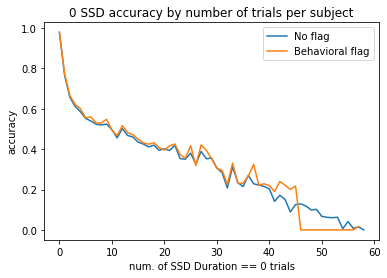

In [23]:
plt.plot(accs_by_cnt1[1:], label='No flag')
plt.plot(accs_by_cnt2[1:], label='Behavioral flag')
plt.title('0 SSD accuracy by number of trials per subject')
plt.ylabel('accuracy')
plt.xlabel('num. of SSD Duration == 0 trials')
plt.legend()
plt.savefig('plots/SSD_acc_by_subj_counts.png')

In [24]:
def get_first_trial(in_df):
    return in_df['StopTrial'].values[0]

bug1 = df1.loc[(df1['SSD.RT'] < 50) & (df1['SSD.RT'] > 0) &
               (df1['SSDDur'] <= 50)]
bug1_subjects = bug1['src_subject_id'].unique()

bug2 = df2.loc[(df2['SSD.RT'] < 50) & (df2['SSD.RT'] > 0) &
               (df2['SSDDur'] <= 50)]
bug2_subjects = bug2['src_subject_id'].unique()

groups1 = bug1.groupby('src_subject_id')
groups2 = bug2.groupby('src_subject_id')

p_start1 = groups1.apply(get_first_trial)
p_start2 = groups2.apply(get_first_trial)

In [25]:
import seaborn as sns

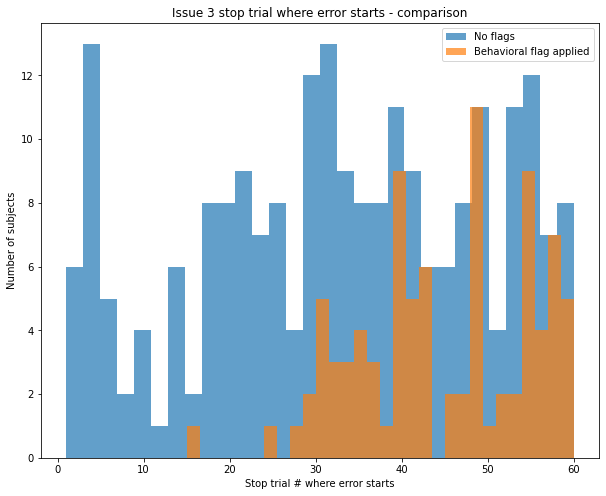

In [26]:
plt.figure(figsize=(10, 8))
plt.title('Issue 3 stop trial where error starts - comparison')
plt.hist(p_start1, bins=30, alpha=.7, label='No flags')
plt.hist(p_start2, bins=30, alpha=.7, label='Behavioral flag applied')
plt.xlabel('Stop trial # where error starts')
plt.ylabel('Number of subjects')
plt.legend()
plt.savefig('plots/Issue3_comparison.png', dpi=300)

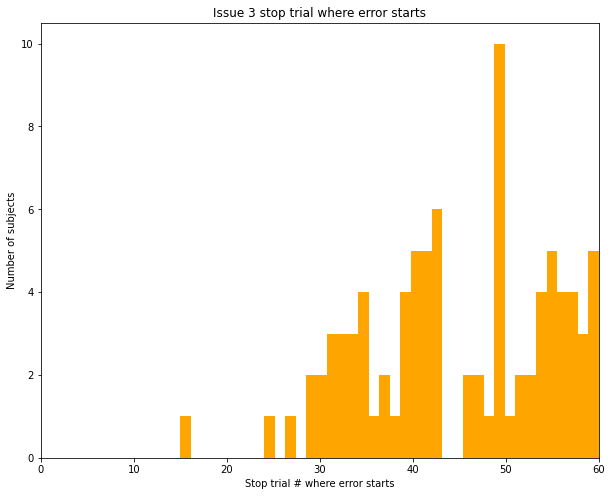

In [27]:
plt.figure(figsize=(10, 8))
plt.title('Issue 3 stop trial where error starts')
plt.hist(p_start2, bins=40, color='orange')
plt.xlabel('Stop trial # where error starts')
plt.ylabel('Number of subjects')
plt.xlim(0, 60)

plt.savefig('plots/Issue3_just_flag.png', dpi=300)

In [28]:
np.sum(p_start1 < 50) / len(zero_cnt1)

0.02165680473372781

In [29]:
np.sum(p_start2 < 50) / len(zero_cnt2)

0.008189894503053859

Issue 3
---------

No Flags (n_subjects = 8451):
2.674% of subjects
0.208% of all trials
1.248% of stop trials

Behavioral flag applied (n_subjects = 7204):
1.235% of subjects
0.560% of all trials
0.336% of stop trials

Their reported results (n_subjects = 7231):
2.724% of subjects
0.211% of all trials

In [30]:
percent_saveable1 = []
percent_saveable2 = []
for x in range(20):
    percent_saveable1.append(np.sum(p_start1 > 59-x) / len(bug1_subjects))
    percent_saveable2.append(np.sum(p_start2 > 59-x) / len(bug2_subjects))

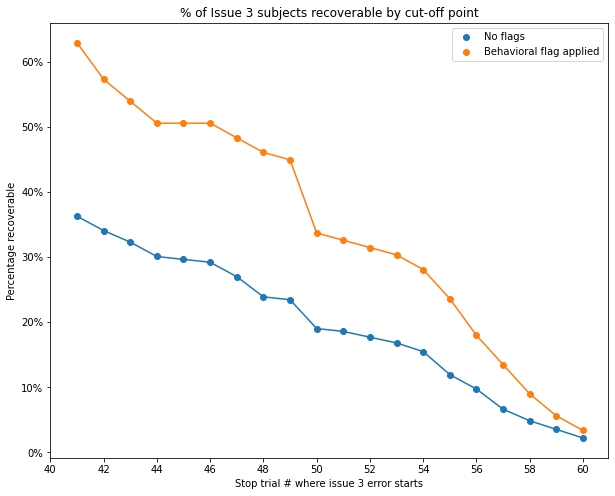

In [31]:
plt.figure(figsize=(10, 8))

plt.scatter([60-x for x in range(0, 20)], percent_saveable1, label='No flags')
plt.plot([60-x for x in range(0, 20)], percent_saveable1)

plt.scatter([60-x for x in range(0, 20)], percent_saveable2, label='Behavioral flag applied')
plt.plot([60-x for x in range(0, 20)], percent_saveable2)

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xticks([60, 58, 56, 54, 52, 50, 48, 46, 44, 42, 40])
plt.xlabel('Stop trial # where issue 3 error starts')
plt.ylabel('Percentage recoverable')
plt.title('% of Issue 3 subjects recoverable by cut-off point')
plt.legend()

plt.savefig('plots/Issue3_percent_recoverable.png', dpi=300)

In [32]:
np.sum(p_start1 > 59) 

5

In [33]:
len(p_start1)

226

In [34]:
np.sum(p_start1 > 59) / len(p_start1)

0.022123893805309734

Issue 4

In [35]:
len(df1.loc[df1['SSDDur'] > 700]) / len(df1.loc[df1['trial_type'] =='StopTrial'])

0.011508265277942163

In [36]:
len(df2.loc[df2['SSDDur'] > 700]) / len(df2.loc[df2['trial_type'] =='StopTrial'])

0.0012076624097723486

In [37]:
n_subjects1 = len(df1.loc[df1['SSDDur'] > 700].src_subject_id.unique())
n_subjects1

408

In [38]:
n_subjects1 / len(df1.src_subject_id.unique())

0.048284023668639056

In [39]:
n_subjects2 = len(df2.loc[df2['SSDDur'] > 700].src_subject_id.unique())
n_subjects2

128

In [40]:
n_subjects2/ len(df2.src_subject_id.unique())

0.01776790671848973

We know it goes from 1.15% of stop trial effected to 0.12% of Stop trials effected by applying the behavioral performance flag. 

We also wanted to look at the # of subjects this effects (atleast once)
Which is 4.83% (408 subjects) w/ no flags applied and 1.78% (128 subjects) with behavioral flags applied

In [41]:
def issue4_cnt(df):
    return len(df.loc[df['SSDDur'] > 700])

group1 = df1.groupby('NARGUID')
group2 = df2.groupby('NARGUID')

long_cnt1 = group1.apply(lambda x: issue4_cnt(x))
long_cnt2 = group2.apply(lambda x: issue4_cnt(x))

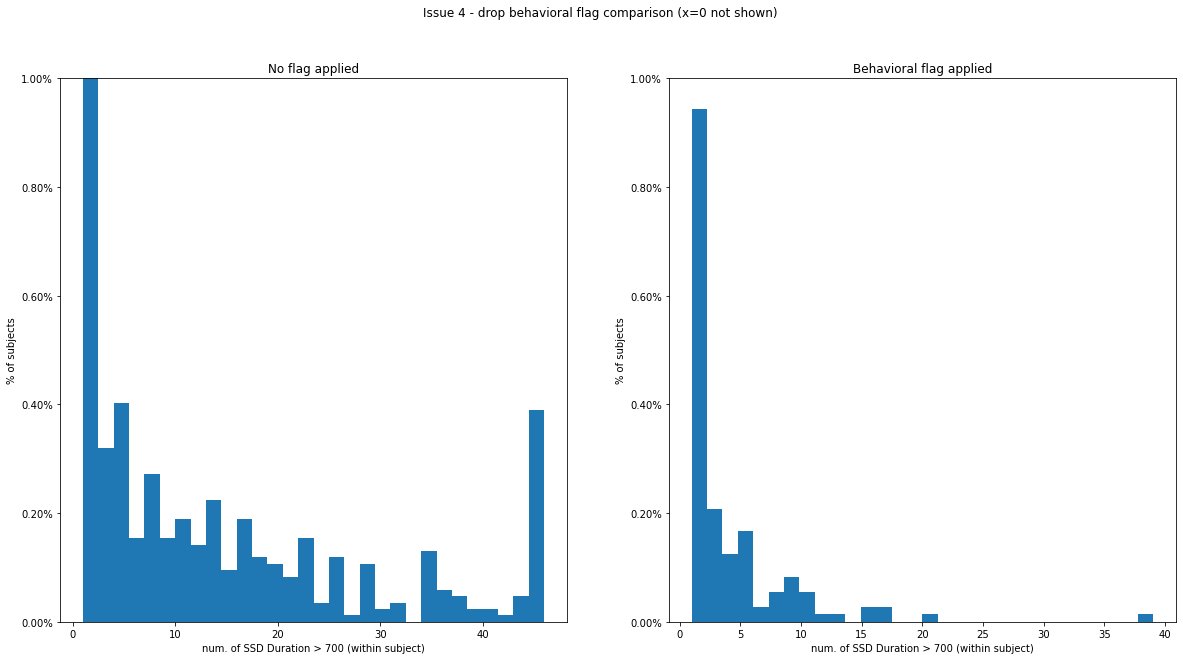

In [42]:
from matplotlib.ticker import PercentFormatter

fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
axes[0].hist(long_cnt1[long_cnt1 != 0], bins=30, weights=np.ones(len(long_cnt1[long_cnt1 != 0])) / len(long_cnt1))
axes[0].set_ylabel('% of subjects')
axes[0].set_xlabel('num. of SSD Duration > 700 (within subject)')
axes[0].yaxis.set_major_formatter(PercentFormatter(1))
axes[0].set_ylim(0, .01)
axes[0].set_title('No flag applied')

axes[1].hist(long_cnt2[long_cnt2 != 0], bins=30, weights=np.ones(len(long_cnt2[long_cnt2 != 0])) / len(long_cnt2))
axes[1].set_ylabel('% of subjects')
axes[1].set_xlabel('num. of SSD Duration > 700 (within subject)')
axes[1].yaxis.set_major_formatter(PercentFormatter(1))
axes[1].set_ylim(0, .01)
axes[1].set_title('Behavioral flag applied')

fig.suptitle('Issue 4 - drop behavioral flag comparison (x=0 not shown)')
plt.savefig('plots/Issue4_behavioral_flag_comparison.png', dpi=300)

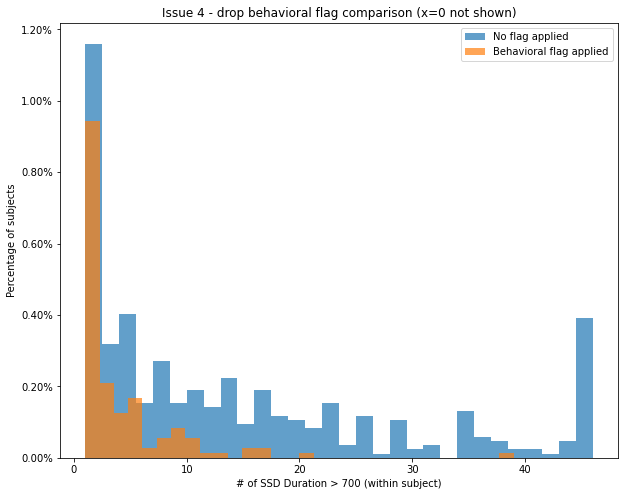

In [43]:
plt.figure(figsize=(10, 8))

plt.title('Issue 4 - drop behavioral flag comparison (x=0 not shown)')

plt.hist(long_cnt1[long_cnt1 != 0],
         bins=30,
         weights=np.ones(len(long_cnt1[long_cnt1 != 0])) / len(long_cnt1),
         label='No flag applied', alpha=.7)

plt.hist(long_cnt2[long_cnt2 != 0],
         bins=30,
         weights=np.ones(len(long_cnt2[long_cnt2 != 0])) / len(long_cnt2),
         label='Behavioral flag applied', alpha=.7)

plt.legend()
plt.ylabel('Percentage of subjects')
plt.xlabel('# of SSD Duration > 700 (within subject)')

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.savefig('plots/issue4_behavioral_comparison.png', dpi=300)

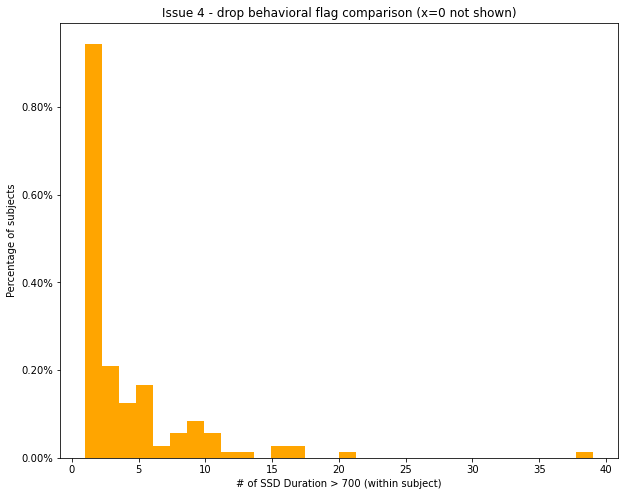

In [44]:
plt.figure(figsize=(10, 8))

plt.title('Issue 4 - drop behavioral flag comparison (x=0 not shown)')


plt.hist(long_cnt2[long_cnt2 != 0],
         bins=30,
         weights=np.ones(len(long_cnt2[long_cnt2 != 0])) / len(long_cnt2),
         alpha=1, color='orange')

plt.ylabel('Percentage of subjects')
plt.xlabel('# of SSD Duration > 700 (within subject)')

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.savefig('plots/issue4_behavioral_just_flag.png', dpi=300)

In [45]:
np.sum(long_cnt1 > 10) / len(long_cnt1)

0.022603550295857987

In [46]:
np.sum(long_cnt2 > 10) / len(long_cnt2)

0.00138811771238201

In [47]:
long_ssd = df1.loc[df1['SSDDur'] > 700]
perc_long = len(long_ssd) / np.sum(df1.trial_type == 'StopTrial')
print('num long ssd trials on all subjects = ', len(long_ssd), '(', perc_long, ')')

long_ssd = df2.loc[df2['SSDDur'] > 700]
perc_long = len(long_ssd) / np.sum(df2.trial_type == 'StopTrial')
print('after behav flag = ', len(long_ssd), '(', perc_long, ')')

num_w_resp = np.sum(~long_ssd['SSD.RESP'].isnull())
print('num w/ SSD resp =', num_w_resp)

new_n = len(long_ssd) - num_w_resp
new_perc = new_n / np.sum(df2.trial_type == 'StopTrial')
print('final # of stop trials w/ shorter stop signal displayed', new_n, '(', new_perc, ')')

num long ssd trials on all subjects =  5834 ( 0.011508265277942163 )
after behav flag =  522 ( 0.0012076624097723486 )
num w/ SSD resp = 212
final # of stop trials w/ shorter stop signal displayed 310 ( 0.0007171941513973718 )


## SSRT calculation

-we should exclude all glitch Ss (1.24%)

-Best practices paper says that SSRT should not be estimated for violators so they should be excluded too from any SSRT analyses we do.

-And we should exclude our performance flagged S

In [48]:
def one_sided_check(x):
    
    go_rts = x.loc[(x['correct_go_response'] != 'omission') &
                   (x['trial_type'] == 'GoTrial')]['go_rt_adjusted']
    stop_rts = x.loc[x['correct_stop'] == 0]['true_stop_rt_adjusted']
    
    t_test_results = ttest_ind(go_rts, stop_rts, equal_var=True)
    
    t = t_test_results[0]
    p = t_test_results[1]
    
    if t < 0 and ((p/2) < .05):
        return False
    else:
        return True
    
def get_sig_vio(group):
    sig = group.apply(one_sided_check)
    return sig[~sig].index

In [49]:
## Drop bugged subjects
SSD_bug = df2.loc[(df2['SSD.RT'] < 50) & (df2['SSD.RT'] > 0) & (df2['SSDDur'] <=50)]['src_subject_id']
to_drop_subjs = SSD_bug.unique()
to_drop = df2[df2.src_subject_id.isin(to_drop_subjs)].index

df = df2.drop(to_drop, axis=0)

In [50]:
# Get go and stop rt
group = df.groupby('src_subject_id')

go_rt = group.apply(lambda x: np.nanmean(x.loc[(x['correct_go_response'] != 'omission') &
                                        (x['trial_type'] == 'GoTrial')]['go_rt_adjusted']))
stop_rt = group.apply(lambda x: np.mean(x.loc[x['correct_stop'] == 0]['true_stop_rt_adjusted']))

In [51]:
stats.ttest_ind(np.array(go_rt), np.array(stop_rt), equal_var=False)

Ttest_indResult(statistic=53.36094911894546, pvalue=0.0)

In [52]:
# Calc violators
vio = stop_rt[stop_rt > go_rt].index
len(vio)

355

In [53]:
# Calc sig signifigant violators
sig_vio = get_sig_vio(group)
len(sig_vio)

115

In [54]:
test_df = df1[df1.src_subject_id == 'NDAR_INV1YFEDW44']

In [55]:
np.sum(~test_df['true_stop_rt_adjusted'].isnull())

60

In [56]:
with open('clean_subj_subset.txt', 'w') as f:
    for subj in df.src_subject_id.unique():
        f.write(subj+'\n')

with open('clean_subj_vio.txt', 'w') as f:
    for subj in vio:
        f.write(subj+'\n')
        
with open('clean_subj_sig_vio.txt', 'w') as f:
    for subj in sig_vio:
        f.write(subj+'\n')

In [57]:
to_drop = df[df.src_subject_id.isin(vio)].index
df_v = df.drop(to_drop, axis=0)
len(df_v.src_subject_id.unique())

6760

In [58]:
to_drop = df[df.src_subject_id.isin(sig_vio)].index
df_sv = df.drop(to_drop, axis=0)
len(df_sv.src_subject_id.unique())

7000

In [91]:
def get_dif_ssrt(s_df, last_only=False, exclude_long=False,
                 exclude_bug=False, exclude_ssd0=False, exclude_first_gos=False):
    
    # Set omissions to max go.rt
    go_trials = s_df.query('trial_type == "GoTrial"')
    
    if exclude_first_gos:
        go_trials = go_trials.iloc[60:]

    go_trials[go_trials['correct_go_response']=="omission"] = go_trials.go_rt_adjusted.max()
    sorted_go = go_trials.go_rt_adjusted.sort_values(ascending=True)
    
    # Get stop trials + prob stop failure
    stop_trials = s_df.query('trial_type == "StopTrial"')
    
    if last_only:
        stop_trials = stop_trials.query('StopTrial > 10')
        if (len(stop_trials) != 50):
            print(s_df.NARGUID.iloc[0], s_df.src_subject_id.iloc[0])
            
    if exclude_long:
        stop_trials = stop_trials.query('SSDDur <= 700')
        
    if exclude_ssd0:
        stop_trials = stop_trials.query('SSDDur != 0')
        
    prob_stop_failure = (1-stop_trials.correct_stop.mean())
    
    # Calc go.rt index
    index = prob_stop_failure * len(sorted_go)
    
    # If prob_stop_failure is 1, use the max go.rt
    if np.ceil(index) == len(sorted_go):
        index = len(sorted_go)-1
    else:
        index = [np.floor(index), np.ceil(index)]
    
    # Calc SSRT
    mean_ssd = np.mean(stop_trials['SSDDur'])
    
    try:
        ssrt = sorted_go.iloc[index].mean() - mean_ssd
    except IndexError:
        print(s_df.NARGUID.iloc[0], s_df.src_subject_id.iloc[0])
        print('index = ', index)
        print('len sorted go =', len(sorted_go))
        print('prob stop fail =', prob_stop_failure)
        ssrt = np.NaN

    return ssrt
        
def get_ssrt(s_df):
    return get_dif_ssrt(s_df)

def get_ssrt_last50(s_df):
    return get_dif_ssrt(s_df, last_only=True)

def get_ssrt_issue(s_df):
    return get_dif_ssrt(s_df, last_only=True, exclude_first_gos=True)

def get_ssrt_exclude_ssd0(s_df):
    return get_dif_ssrt(s_df, exclude_ssd0=True)

def get_ssrt_exclude_long(s_df):
    return get_dif_ssrt(s_df, exclude_long=True)

def get_no_vio_df(df):
    
    group = df.groupby('src_subject_id')

    go_rt = group.apply(lambda x: np.nanmean(x.loc[(x['correct_go_response'] != 'omission') &
                                            (x['trial_type'] == 'GoTrial')]['go_rt_adjusted']))
    stop_rt = group.apply(lambda x: np.mean(x.loc[x['correct_stop'] == 0]['true_stop_rt_adjusted']))

    vio = stop_rt[stop_rt > go_rt].index

    to_drop = df[df.src_subject_id.isin(vio)].index
    df_no_v = df.drop(to_drop, axis=0)

    return df_no_v


def prep(s_df):

    go_trials = s_df.query('trial_type == "GoTrial"')
    go_trials[go_trials['correct_go_response']=="omission"] = go_trials.go_rt_adjusted.max()
    sorted_go = go_trials.go_rt_adjusted.sort_values(ascending=True)
    sorted_go = np.array(sorted_go)

    stop_trials = s_df.query('trial_type == "StopTrial"')
    stops = np.array(stop_trials[['correct_stop', 'SSDDur', 'StopTrial', 'SSD.RT']])
        
    return sorted_go, stops

def unpack(prep):
    
    sorted_gos = []
    stops = []
    for i in prep.index:
        sorted_gos.append(prep.loc[i][0])
        stops.append((prep.loc[i][1]))

    sorted_gos = np.array(sorted_gos)
    stops = np.array(stops)

    return sorted_gos, stops

def fast_calc(sorted_gos, stops, remove_rand=0, last_only=False,
              last_only_alt=False, exclude_long=False,
              exclude_bug=False, exclude_ssd0=False):
    
    gos = sorted_gos.copy()
    
    correct_stop = stops[:,:,0].copy()
    ssd_dur = stops[:,:,1].copy()
    stop_trial = stops[:,:,2].copy()
    
    if last_only:
        lo = np.where(stop_trial <= 10)
        correct_stop[lo] = np.nan
        ssd_dur[lo] = np.nan
        
    if last_only_alt:
        lo = np.where(stop_trial <= 7)
        correct_stop[lo] = np.nan
        ssd_dur[lo] = np.nan
        
    if exclude_long:
        long = np.where(ssd_dur > 700)
        correct_stop[long] = np.nan
        ssd_dur[long] = np.nan

    if exclude_ssd0:
        ssd0 = np.where(ssd_dur == 0)
        correct_stop[ssd0] = np.nan
        ssd_dur[ssd0] = np.nan
    
    # By taking the nanmean, ignores all stops that have been set to NaN
    prob_stop_failure = 1 - np.nanmean(correct_stop, axis=1)
    
    index = prob_stop_failure * gos.shape[1]
    
    # If index @ max, have to decrement, but will still
    # take max value
    index[np.where(index == gos.shape[1])] -= 1
    
    f_index = np.floor(index).astype(int)
    c_index = np.ceil(index).astype(int)
    
    # Same as before, take nanmean
    mean_ssd = np.nanmean(ssd_dur, axis=1)
    
    f = gos[(np.arange(0, len(f_index)), f_index)]
    c = gos[(np.arange(0, len(c_index)), c_index)]

    go_loc = np.mean([f,c], axis=0)
    ssrts = go_loc - mean_ssd
    return ssrts

Want to start by confirming that both methods to calc ssrt work the same - then we can use the fast one

In [60]:
group_v = df_v.groupby('src_subject_id')
group_sv = df_sv.groupby('src_subject_id')

p1 = group_v.apply(prep)
sorted_gos_v, stops_v = unpack(p1)

In [61]:
np.mean(group_v.apply(get_ssrt)), np.mean(fast_calc(sorted_gos_v, stops_v))

(282.6311390532549, 282.63113905325446)

In [62]:
np.mean(group_v.apply(get_ssrt_last50)), np.mean(fast_calc(sorted_gos_v, stops_v, last_only=True))

(277.30939349112424, 277.30939349112424)

In [63]:
np.mean(group_v.apply(get_ssrt_exclude_long)), np.mean(fast_calc(sorted_gos_v, stops_v, exclude_long=True))

(282.83657322158535, 282.8365732215849)

In [64]:
np.mean(group_v.apply(get_ssrt_exclude_ssd0)), np.mean(fast_calc(sorted_gos_v, stops_v, exclude_ssd0=True))

(275.9980898209979, 275.9980898209973)

In [65]:
np.mean(go_rt.loc[p1.index])

544.4223896400448

In [66]:
base_ssrt_v = fast_calc(sorted_gos_v, stops_v)
np.mean(base_ssrt_v), np.std(base_ssrt_v)

(282.63113905325446, 77.96260508644481)

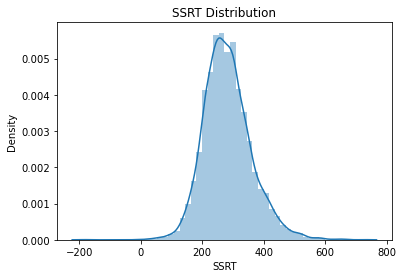

In [67]:
plt.title('SSRT Distribution')
sns.distplot(base_ssrt_v)
plt.xlabel('SSRT')
plt.savefig('plots/SSRT_dist.png', dpi=500)

In [68]:
# Index go_rt by the p1 index to get them to line up
pearsonr(base_ssrt_v, go_rt.loc[p1.index])

(-0.036897935907011854, 0.0024118118987842647)

In [69]:
ssrt_ssd0 = fast_calc(sorted_gos_v, stops_v, exclude_ssd0=True)
np.mean(ssrt_ssd0), np.std(ssrt_ssd0), pearsonr(base_ssrt_v, ssrt_ssd0)

(275.9980898209973, 73.37035295387585, (0.9737250359714896, 0.0))

In [70]:
ssrt_long = fast_calc(sorted_gos_v, stops_v, exclude_long=True)
np.mean(ssrt_long), np.std(ssrt_long), pearsonr(base_ssrt_v, ssrt_long)

(282.8365732215849, 77.59039441707243, (0.999025774310121, 0.0))

In [71]:
ssrt_last = fast_calc(sorted_gos_v, stops_v, last_only=True)
np.mean(ssrt_last), np.std(ssrt_last), pearsonr(base_ssrt_v, ssrt_last)

(277.30939349112424, 84.75488252287573, (0.9759216336880274, 0.0))

In [72]:
ssrt_last_alt = fast_calc(sorted_gos_v, stops_v, last_only_alt=True)
np.mean(ssrt_last_alt), np.std(ssrt_last_alt), pearsonr(base_ssrt_v, ssrt_last_alt)

(277.3257228982918, 82.6861756987653, (0.9852890530189269, 0.0))

- Descriptive stat for SSRT group mean and std.dev:

mean = 282.6311390
std = 77.962605

- Correlation between Go RT and SSRT (Issue 1):

r=-0.0368979, p=0.002412

- Calculation of SSRT with all 0msec SSD trials removed (Issue 3):

mean = 275.99808
std = 73.370352
r w/ base = .973725

- Calculation of SSRT when the long SSD trials are removed (Issue 4):

mean = 282.836573
std = 77.590394
r w/ base = 0.999025

- Calculation of SSRT when the first ten Stop trials are removed (Issue 7) (w/o sticky issue):

mean = 277.309393
std = 84.7548825
r w/ base = .975922

- W/ both first 10 stop trials and first 60 go trials removed

mean = 284.4214497
std = 85.06956628
r w/ base = .9736803


In [73]:
# Harder to remove the go trials the way the fast version is setup
ssrt_issue = group_v.apply(get_ssrt_issue)

In [74]:
np.mean(ssrt_issue), np.std(ssrt_issue), pearsonr(base_ssrt_v, ssrt_issue)

(284.421449704142, 85.06956628523224, (0.973680375772655, 0.0))

## How do go_rts change over time?

In [75]:
def get_block_rt(ex_df):
    trial_types = np.zeros(len(ex_df))
    trial_types[np.where(ex_df['trial_type'] == 'GoTrial')] = 1
    go_rts = np.array(ex_df['go_rt_adjusted'])

    block_go_rts = []

    x = 0
    for i, y in enumerate(np.where(trial_types == 0)[0]):
        block_go_rts.append(np.mean(go_rts[x:y]))
        x = y+1

    return np.array(block_go_rts)

In [76]:
block_go_rts = group.apply(get_block_rt)

In [77]:
stacked_go_rts = []
for ind in block_go_rts.index:
    stacked_go_rts.append(block_go_rts.loc[ind])
stacked_go_rts = np.array(stacked_go_rts)

In [78]:
stacked_go_rts.shape

(7115, 60)

In [79]:
np.mean(stacked_go_rts, axis=0)[3]

485.63931014289045

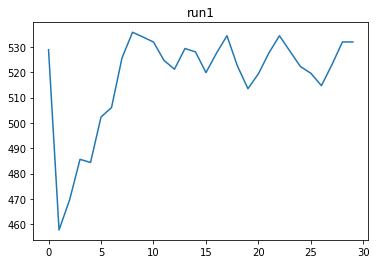

In [80]:
plt.plot(np.mean(stacked_go_rts, axis=0)[:30])
plt.title('run1')
plt.savefig('plots/go_rt_by_trial1.png')

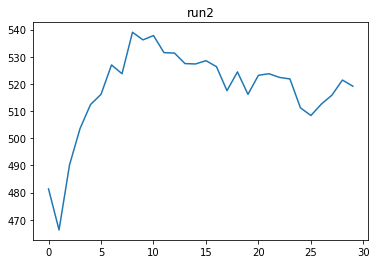

In [81]:
plt.plot(np.mean(stacked_go_rts, axis=0)[30:])
plt.title('run2')
plt.savefig('plots/go_rt_by_trial2.png')

## Descriptive stats on violators

In [82]:
def get_stop_succ_rate(df):
    
    stop_trials = df[df['trial_type'] == 'StopTrial']
    return np.sum(stop_trials['correct_stop']) / len(stop_trials)

def get_go_omissions_rate(df):

    go_trials = df[df['trial_type'] == 'GoTrial']
    return np.sum(go_trials['correct_go_response'] == 'omission') / len(go_trials)

def get_avg_ssd(df):
    stop_trials = df[df['trial_type'] == 'StopTrial']
    return np.mean(stop_trials['SSDDur'])

def get_avg_go_rt(df):
    
    return np.nanmean(df.loc[(df['correct_go_response'] != 'omission') &
                     (df['trial_type'] == 'GoTrial')]['go_rt_adjusted'])

def get_avg_stop_rt(df):
    
    return np.mean(df.loc[df['correct_stop'] == 0]['true_stop_rt_adjusted'])

def get_comparison(subj_stats, vio):
    
    non_vio = list(set(subj_stats.index) - set(vio))
    
    print('all:', np.mean(subj_stats))
    print('vio:', np.mean(subj_stats.loc[vio]))
    print('non-vio:', np.mean(subj_stats.loc[non_vio]))

In [83]:
def calc_for_group(group):
    stop_succ_rate = group.apply(get_stop_succ_rate)
    stop_fail_acc = group.apply(stop_fail_accuracy)
    go_acc = group.apply(go_accuracy)
    go_om_rate = group.apply(get_go_omissions_rate)
    avg_ssd = group.apply(get_avg_ssd)
    go_rt = group.apply(get_avg_go_rt)
    stop_rt = group.apply(get_avg_stop_rt)

    stats = [stop_succ_rate, stop_fail_acc, go_rt, stop_rt, go_acc, go_om_rate, avg_ssd]
    return stats
    

In [84]:
all_subjs = calc_for_group(df1.groupby('src_subject_id'))
ex_behav = calc_for_group(df2.groupby('src_subject_id'))
ex_bug = calc_for_group(df.groupby('src_subject_id'))
ex_vio = calc_for_group(df_v.groupby('src_subject_id'))

In [85]:
names = ['Stop succ. rate', 'Stop fail acc.', 'Go RT',
         'Stop Fail RT', 'Go acc.', 'Go omission rate',
         'Avg. SSD']

for i, name in enumerate(names):
    
    print(name+': ', end='')
    print("{:.3f}".format(np.mean(all_subjs[i])),
          "{:.3f}".format(np.mean(ex_behav[i])),
          "{:.3f}".format(np.mean(ex_bug[i])),
          "{:.3f}".format(np.mean(ex_vio[i])),
           sep=' -> ')
    print()

Stop succ. rate: 0.510 -> 0.513 -> 0.516 -> 0.519

Stop fail acc.: 0.786 -> 0.805 -> 0.808 -> 0.813

Go RT: 543.186 -> 542.953 -> 543.846 -> 544.422

Stop Fail RT: 459.140 -> 458.196 -> 460.484 -> 452.562

Go acc.: 0.892 -> 0.909 -> 0.910 -> 0.912

Go omission rate: 0.073 -> 0.046 -> 0.046 -> 0.045

Avg. SSD: 231.272 -> 227.368 -> 229.138 -> 234.045



In [86]:
to_save = pd.DataFrame()

for i, name in enumerate(names):
    to_save[name] = ex_bug[i]

to_save.to_csv('Summaries.csv')

In [87]:
just_vio_df = df.loc[df.src_subject_id.isin(vio)]
len(just_vio_df .src_subject_id.unique())

355

In [88]:
just_vio = calc_for_group(just_vio_df.groupby('src_subject_id'))

In [89]:
for i, name in enumerate(names):
    
    print(name)
    ttest_result = ttest_ind(np.array(just_vio[i]), np.array(ex_vio[i]), equal_var=True)
    print('Just Violators:', "{:.3f}".format(np.mean(just_vio[i])), 'Violators Excluded:', 
          "{:.3f}".format(np.mean(ex_vio[i])))
    print(ttest_result)
    print()

Stop succ. rate
Just Violators: 0.457 Violators Excluded: 0.519
Ttest_indResult(statistic=-20.275393638530627, pvalue=6.652862111798956e-89)

Stop fail acc.
Just Violators: 0.705 Violators Excluded: 0.813
Ttest_indResult(statistic=-13.265686634649304, pvalue=1.0811508363775074e-39)

Go RT
Just Violators: 532.873 Violators Excluded: 544.422
Ttest_indResult(statistic=-2.344258886801527, pvalue=0.01909229854630685)

Stop Fail RT
Just Violators: 611.344 Violators Excluded: 452.562
Ttest_indResult(statistic=32.64605970109036, pvalue=5.886643138341828e-218)

Go acc.
Just Violators: 0.882 Violators Excluded: 0.912
Ttest_indResult(statistic=-5.021171190192575, pvalue=5.26064853926075e-07)

Go omission rate
Just Violators: 0.064 Violators Excluded: 0.045
Ttest_indResult(statistic=7.129943235183358, pvalue=1.1029906744028104e-12)

Avg. SSD
Just Violators: 135.704 Violators Excluded: 234.045
Ttest_indResult(statistic=-17.73378134743226, pvalue=6.882458105890803e-69)



## Calculate SSRT's by a few different subgroups

In [92]:
# First subset
df_full = pd.read_csv('merged_data/1_.csv', low_memory=False)
df_full = clean_df(df_full, switch=True)

# Need to drop broken subj
to_drop = df_full[df_full['NARGUID'] == 'HJAUY52L'].index
df_full = df_full.drop(to_drop, axis=0)

# No vio version
df_full_no_v = get_no_vio_df(df_full)

# First subset w/o bugged
SSD_bug = df_full.loc[(df_full['SSD.RT'] < 50) & (df_full['SSD.RT'] > 0) & (df_full['SSDDur'] <=50)]['src_subject_id']
to_drop_subjs = SSD_bug.unique()
to_drop = df_full[df_full.src_subject_id.isin(to_drop_subjs)].index
df_full_no_bug = df_full.drop(to_drop, axis=0)

# No vio version
df_full_no_bug_no_v = get_no_vio_df(df_full_no_bug)

# With behav flag dropped
# Same subset but w/ behavioral flag applied
df_no_behav = pd.read_csv('merged_data/5_.csv', low_memory=False)
df_no_behav = clean_df(df_no_behav, switch=True)

# No vio version
df_no_behav_no_v = get_no_vio_df(df_no_behav)

# No behav, no bug
SSD_bug = df_no_behav.loc[(df_no_behav['SSD.RT'] < 50) & (df_no_behav['SSD.RT'] > 0) & (df_no_behav['SSDDur'] <=50)]['src_subject_id']
to_drop_subjs = SSD_bug.unique()
to_drop = df_no_behav[df_no_behav.src_subject_id.isin(to_drop_subjs)].index
df_no_behav_no_bug = df_no_behav.drop(to_drop, axis=0)

# No vio version
df_no_behav_no_bug_no_v = get_no_vio_df(df_no_behav_no_bug)

In [93]:
def get_ssrts(df):
    
    # Group and prep
    group = df.groupby('src_subject_id')
    
    # Prep ... 
    sorted_gos, stops = unpack(group.apply(prep))
    
    # Get base ssrts
    ssrts = fast_calc(sorted_gos, stops)
    print('Base - Mean:', np.mean(ssrts), 'Std:', np.std(ssrts))
    
    ssrts = fast_calc(sorted_gos, stops, exclude_ssd0=True)
    print('No 0SSD - Mean:', np.mean(ssrts), 'Std:', np.std(ssrts))

In [94]:
get_ssrts(df_full)

Base - Mean: 312.014360673847 Std: 194.73067125589756
No 0SSD - Mean: 295.93475945975257 Std: 169.38569677265846


In [95]:
get_ssrts(df_full_no_v)

Base - Mean: 300.7182999872563 Std: 179.9301005538753
No 0SSD - Mean: 285.2001365849965 Std: 150.4646454800635


In [96]:
get_ssrts(df_full_no_bug)

Base - Mean: 296.0909846365884 Std: 145.7149727569782
No 0SSD - Mean: 286.5077913195545 Std: 139.02539931639225


In [97]:
get_ssrts(df_full_no_bug_no_v)

Base - Mean: 283.32257923497264 Std: 117.495573722062
No 0SSD - Mean: 274.81615565923215 Std: 110.20662519582251


In [98]:
get_ssrts(df_no_behav)

Base - Mean: 291.28812696650016 Std: 91.31346631310763
No 0SSD - Mean: 283.6362699494149 Std: 87.5584819094059


In [99]:
get_ssrts(df_no_behav_no_v)

Base - Mean: 285.57134861536963 Std: 85.4993953800454
No 0SSD - Mean: 277.43879091830865 Std: 77.02720888029698


In [100]:
get_ssrts(df_no_behav_no_bug)

Base - Mean: 288.56612789880535 Std: 84.92840284754696
No 0SSD - Mean: 282.34497496922427 Std: 84.74915173848085


In [101]:
get_ssrts(df_no_behav_no_bug_no_v)

Base - Mean: 282.63113905325446 Std: 77.96260508644481
No 0SSD - Mean: 275.9980898209973 Std: 73.37035295387585
